In [282]:
from sklearn.model_selection import KFold, StratifiedKFold
from colorama import Fore, Back, Style
from sklearn.linear_model import LogisticRegression, HuberRegressor
import feature_engine as fe
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.impute import IterativeImputer
from feature_engine.encoding import WoEEncoder
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)


訓練データとテストデータの読み込み

In [283]:
train = pd.read_csv("../data/train.csv", index_col="id")
test = pd.read_csv("../data/test.csv", index_col="id")


In [284]:
train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [285]:
test.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,,,,
26570,F,119.57,material_5,material_6,6,4,6,9,6,19.305,10.178,17.534,18.168,11.598,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
26571,F,113.51,material_5,material_6,6,4,11,8,0,17.883,11.927,17.228,16.033,11.179,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
26572,F,112.16,material_5,material_6,6,4,8,12,4,18.475,10.481,16.619,18.189,12.126,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
26573,F,112.72,material_5,material_6,6,4,8,11,10,16.518,10.888,15.293,18.592,11.304,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
26574,F,208.00,material_5,material_6,6,4,14,16,8,17.808,12.693,17.678,15.814,13.431,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


In [286]:
#訓練データとテストデータを結合させる

#訓練データとテストデータを識別するためのtrainラベルを訓練データとテストデータに付与する
train["train"] = True
test["train"] = False

#テストデータの目的変数を適当にセットする
test["failure"] = 99999

#訓練データとテストデータを結合
train_test = train.append(test)


False
False


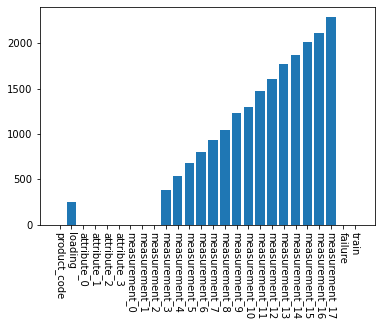

In [287]:
#欠損値がないか確認（nullが1つもなければ以下のprint文でTrueが出力される）
print(np.all(train.isnull().sum() == 0))
print(np.all(test.isnull().sum() == 0))

train_miss = train.isnull().sum()
plt.bar(train_miss.index, train_miss)
plt.xticks(rotation=270)
plt.show()


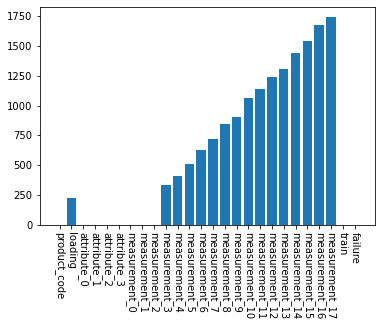

In [288]:
test_miss = test.isnull().sum()
plt.bar(test_miss.index, test_miss)
plt.xticks(rotation=270)
plt.show()


In [289]:
#loadingにlogを乗じて分布を正規分布に近づける
train_test['loading'] = np.log(train_test["loading"])

#mesurement3とmesurement5の欠損値の数
train_test['measurement_3_na'] = train_test['measurement_3'].isnull().astype(int)
train_test['measurement_5_na'] = train_test['measurement_5'].isnull().astype(int)


In [290]:
#欠損値補完（特徴量ごとの平均値を採用）
#train_test.fillna(train_test.mean(), inplace=True)

#欠損値がないか確認（nullが1つもなければTrueが出力される）
print(np.all(train_test.isnull().sum() == 0))
train_test.dtypes


False


product_code         object
loading             float64
attribute_0          object
attribute_1          object
attribute_2           int64
attribute_3           int64
measurement_0         int64
measurement_1         int64
measurement_2         int64
measurement_3       float64
measurement_4       float64
measurement_5       float64
measurement_6       float64
measurement_7       float64
measurement_8       float64
measurement_9       float64
measurement_10      float64
measurement_11      float64
measurement_12      float64
measurement_13      float64
measurement_14      float64
measurement_15      float64
measurement_16      float64
measurement_17      float64
failure               int64
train                  bool
measurement_3_na      int32
measurement_5_na      int32
dtype: object

In [291]:

# IterativeImputerで欠損値補完
num_cols = [col for col in train_test.columns[:-1] if (train_test[col].dtypes == 'float64')]
print(num_cols)
for code in train_test['product_code'].unique():
    print(code)
    imputer = IterativeImputer(
        max_iter=8, random_state=0, skip_complete=True, n_nearest_features=12)
    train_test.loc[train_test['product_code'] == code, num_cols] = imputer.fit_transform(
        train_test.loc[train_test['product_code'] == code, num_cols])
print(np.all(train_test.isnull().sum() == 0))
train_test.dtypes


['loading', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']
A


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


B


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


C


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


D


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


E


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


F


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


G


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


H


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


I
True


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


product_code         object
loading             float64
attribute_0          object
attribute_1          object
attribute_2           int64
attribute_3           int64
measurement_0         int64
measurement_1         int64
measurement_2         int64
measurement_3       float64
measurement_4       float64
measurement_5       float64
measurement_6       float64
measurement_7       float64
measurement_8       float64
measurement_9       float64
measurement_10      float64
measurement_11      float64
measurement_12      float64
measurement_13      float64
measurement_14      float64
measurement_15      float64
measurement_16      float64
measurement_17      float64
failure               int64
train                  bool
measurement_3_na      int32
measurement_5_na      int32
dtype: object

In [292]:
#ラベルエンコーディングを実施

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_test["product_code"])
train_test["product_code"] = le.transform(train_test["product_code"])
le.fit(train_test["attribute_0"])
train_test["attribute_0"] = le.transform(train_test["attribute_0"])
le.fit(train_test["attribute_1"])
train_test["attribute_1"] = le.transform(train_test["attribute_1"])
train_test.dtypes

product_code          int32
loading             float64
attribute_0           int32
attribute_1           int32
attribute_2           int64
attribute_3           int64
measurement_0         int64
measurement_1         int64
measurement_2         int64
measurement_3       float64
measurement_4       float64
measurement_5       float64
measurement_6       float64
measurement_7       float64
measurement_8       float64
measurement_9       float64
measurement_10      float64
measurement_11      float64
measurement_12      float64
measurement_13      float64
measurement_14      float64
measurement_15      float64
measurement_16      float64
measurement_17      float64
failure               int64
train                  bool
measurement_3_na      int32
measurement_5_na      int32
dtype: object

In [293]:
#Onehotエンコーディングを実施
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, drop='first')
col = ["attribute_0", "attribute_1", "attribute_2", "attribute_3"]
ohe.fit(train_test[col])
print(ohe.categories_)
ohe.fit(train_test[col])
print(ohe.categories_)

[array([0, 1]), array([0, 1, 2, 3]), array([5, 6, 7, 8, 9], dtype=int64), array([4, 5, 6, 7, 8, 9], dtype=int64)]
[array([0, 1]), array([0, 1, 2, 3]), array([5, 6, 7, 8, 9], dtype=int64), array([4, 5, 6, 7, 8, 9], dtype=int64)]


In [294]:
#特徴量追加

#mesurement3とmesurement5の積
train_test['measurement(3*5)'] = train_test['measurement_3'] * train_test['measurement_5']
train_test['measurement(3*5)'] = train_test['measurement_3'] * train_test['measurement_5']



#attribute_2とattribute_3の積
train_test['attribute_2*3'] = train_test['attribute_2'] * train_test['attribute_3']

#['measurement_3', 'measurement_4', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16']の平均と分散
meas_gr1_cols = [f"measurement_{i:d}" for i in list(range(3, 5)) + list(range(9, 17))]
print(meas_gr1_cols)
train_test['meas_gr1_avg'] = np.mean(train_test[meas_gr1_cols], axis=1)
train_test['meas_gr1_std'] = np.std(train_test[meas_gr1_cols], axis=1)

#['measurement_5', 'measurement_6', 'measurement_7', 'measurement_8']の平均と分散
meas_gr2_cols = [f"measurement_{i:d}" for i in list(range(5, 9))]
print(meas_gr2_cols)
train_test['meas_gr2_avg'] = np.mean(train_test[meas_gr2_cols], axis=1)


['measurement_3', 'measurement_4', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16']
['measurement_5', 'measurement_6', 'measurement_7', 'measurement_8']


In [295]:
train_test['measurement_3_na'].isnull().sum()


0

In [296]:
#訓練データとテストデータを再分割（数値データの標準化前にやっておかないといけない）

train = train_test[train_test["train"] == True]
train= train.drop(["train"], axis = 1)

test = train_test[train_test["train"] == False]
test= test.drop(["train", "failure"], axis = 1)

In [297]:
#データを標準化する列を抽出（数値変数のみ）
cols = [col for col in train.columns if train[col].dtypes == 'float64']
print(cols)
train[cols] = (train[cols] - train[cols].mean()) / train[cols].std(ddof=0)
test[cols] = (test[cols] - test[cols].mean()) / test[cols].std(ddof=0)


['loading', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17', 'measurement(3*5)', 'meas_gr1_avg', 'meas_gr1_std', 'meas_gr2_avg']


In [298]:
train

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,measurement_3_na,measurement_5_na,measurement(3*5),attribute_2*3,meas_gr1_avg,meas_gr1_std,meas_gr2_avg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,-1.425982,1,3,9,5,7,8,4,0.249462,0.794473,-1.393066,1.808621,0.021268,1.127738,-0.775990,-0.188286,-1.063240,2.408750,-0.555076,-0.432632,-1.304746,-1.072596,0.507535,0,0,0,-0.836381,45,-0.731839,-1.808225,0.777528
1,0,-1.230159,1,3,9,5,14,3,3,0.423252,-0.193648,0.594559,0.389202,1.036361,-1.130955,1.039369,1.330590,-0.846985,0.037461,-0.819771,-0.431609,-0.400070,-0.501215,-0.157805,0,0,0,0.726186,45,-0.264232,-1.089093,0.434042
2,0,-1.329307,1,3,9,5,12,1,5,0.266540,-0.080489,-0.393702,0.741267,1.006180,-0.733241,1.312286,-0.371599,0.669608,1.446578,0.943972,1.783191,-0.600149,0.895560,-0.309302,0,0,0,-0.101618,45,1.979004,-0.370506,0.302547
3,0,-0.641961,1,3,9,5,13,2,6,-0.498943,-0.549290,1.461684,0.841712,0.870365,0.036269,1.062879,0.165973,-0.535740,-1.159218,-0.358114,-0.336965,0.769161,0.428560,1.011810,0,0,0,0.669175,45,-0.303948,-0.393751,1.589496
4,0,1.451622,1,3,9,5,9,2,8,1.561430,1.230943,-0.139318,-1.789133,-0.414347,-0.927613,-1.118414,0.701362,0.511848,0.501649,0.472512,-2.272669,-1.225645,-0.029992,-0.986385,0,0,0,0.969518,45,-0.125229,0.609240,-1.621877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,4,0.884617,1,1,6,9,6,16,4,-1.497485,1.543140,0.948879,-2.033651,-0.858010,0.329321,-0.447578,-2.866688,-0.828796,-1.095763,0.127606,1.742432,0.762514,-0.405412,0.223949,0,0,0,-0.413906,54,-0.961864,-0.139084,-0.793410
26566,4,0.598550,1,1,6,9,10,12,8,-0.249809,-0.955754,0.864084,1.591498,-0.582355,0.537647,-0.193358,-1.410371,0.937621,-1.011616,-1.071097,-1.193594,-1.230298,0.005606,1.235977,0,0,0,0.435165,54,-1.954357,0.705040,1.192512
26567,4,-0.188496,1,1,6,9,1,10,1,-2.131369,-0.198700,-0.353323,0.888383,-0.088390,0.254563,-0.024701,0.232169,-1.142735,-2.091732,-0.519426,0.379425,0.394263,-1.446075,0.396141,0,0,0,-1.694193,54,-2.055009,-0.333309,0.346545


In [299]:
test

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,measurement_3_na,measurement_5_na,measurement(3*5),attribute_2*3,meas_gr1_avg,meas_gr1_std,meas_gr2_avg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26570,5,-0.068610,0,1,6,4,6,9,6,1.518450,-1.539458,0.395443,0.657957,-0.115270,-0.377973,-0.624183,-0.140219,-0.499981,1.403245,-1.573931,0.512648,-0.918599,0.674738,-0.515737,0,0,1.366060,24,-0.349046,0.426333,0.279222
26571,5,-0.243376,0,1,6,4,11,8,0,0.090265,0.199011,0.089833,-1.494244,-0.537915,0.339872,0.621795,-1.389975,-0.589660,0.422955,1.311132,0.427168,-0.226601,-1.593369,-1.264542,0,0,0.128572,24,-0.510205,-1.200891,-0.793822
26572,5,-0.283579,0,1,6,4,8,12,4,0.684840,-1.238282,-0.518392,0.679126,0.417323,-1.262710,0.329041,0.603356,-0.489685,-0.758827,-1.798131,-0.282241,1.305297,-0.387023,-0.328619,0,0,0.085744,24,-0.599497,0.281795,-0.343804
26573,5,-0.266844,0,1,6,4,8,11,10,-1.280672,-0.833733,-1.842703,1.085373,-0.411828,-0.082390,0.376651,1.335159,-1.727116,-0.739206,-0.178739,-0.333383,-1.669490,-0.330446,-0.825090,0,0,-2.129373,24,-1.691157,-0.689067,-0.629316
26574,5,1.791710,0,1,6,4,14,16,8,0.014939,0.960399,0.539260,-1.715008,1.733676,0.111649,0.964186,-1.010667,-0.642192,0.021481,0.252240,0.043605,-1.198343,0.322704,0.761485,0,0,0.402133,24,-0.350479,-1.466360,0.334224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47340,8,0.573310,1,0,9,5,0,4,9,0.674796,0.838140,1.006664,-0.429736,-0.512698,-0.459409,0.276365,0.000087,0.594594,-0.264531,1.142981,-0.724983,0.063181,0.581157,-0.041061,0,0,1.226543,45,0.931332,-0.109089,-0.191797
47341,8,-1.656970,1,0,9,5,4,8,7,1.111688,-1.819760,1.148483,-0.000968,0.035026,-1.118941,-0.443871,-0.063050,-2.028912,1.246277,-0.184041,-0.604434,-0.871752,-0.085279,-0.679680,0,0,1.657034,45,-1.259081,-0.601132,0.035383
47342,8,-1.978447,1,0,9,5,10,11,2,0.866627,0.678295,1.102542,0.397878,0.371932,0.603282,-0.994937,0.008888,1.135769,-0.587521,0.592328,-0.437128,-0.628817,0.686053,0.625691,0,0,1.440494,45,0.453733,0.980690,1.233762


In [300]:
auc_list = []
test_pred_list = []
importance_list = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_label = train["failure"]
train = train.drop(["failure"], axis=1)
feature_importance = []


Fold 0: auc = 0.58690
Fold 1: auc = 0.58583
Fold 2: auc = 0.58162
Fold 3: auc = 0.57394
Fold 4: auc = 0.56780
Average auc = 0.57922



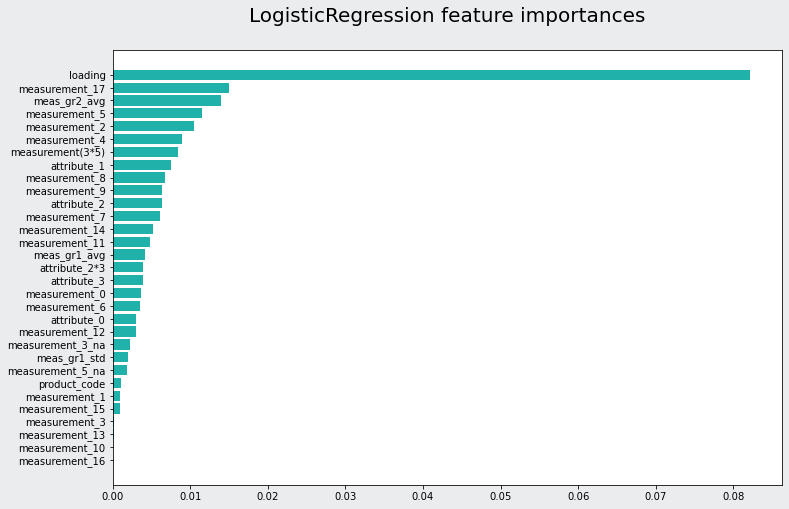

In [301]:
for fold, (idx_tr, idx_va) in enumerate(skf.split(X=train, y=train_label)):
    X_tr = train.iloc[idx_tr]
    X_va = train.iloc[idx_va]
    y_tr = train_label.loc[idx_tr]
    y_va = train_label.loc[idx_va]

    # LR with GridSearch
    #model = LogisticRegression(
        #max_iter=500, solver='newton-cg', random_state=42)
    #param_grid = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1], 'penalty':['l2']}
    #clf = GridSearchCV(model, param_grid, verbose = 0)
    
    clf = LogisticRegression(C=0.0001, penalty='l2', solver='newton-cg')
    
    clf.fit(X_tr, y_tr)
    #best_clf = clf.best_estimator_
    #print(clf.best_params_)
    #importance_list.append(clf.coef_.ravel())
    
    # Validate model
    va_preds = clf.predict_proba(X_va)[:, 1]
    score = roc_auc_score(y_va, va_preds)
    print(f"Fold {fold}: auc = {score:.5f}")
    auc_list.append(score)
    
    # Test set predictions
    test_pred_list.append(clf.predict_proba(test)[:,1])
    
print(f'Average auc = {sum(auc_list) / len(auc_list):.5f}')
print('')
preds = sum(test_pred_list)/len(test_pred_list)

feature_importance.append(clf.coef_.ravel())
importance_df = pd.DataFrame(
    np.array(feature_importance).T, index=train.columns)
importance_df['mean'] = importance_df.mean(axis=1).abs()
importance_df['feature'] = train.columns
importance_df = importance_df.sort_values('mean', ascending=True).reset_index()

fig, ax = plt.subplots(figsize=(12, 8), facecolor='#EAECEE')
plt.barh(importance_df.index, importance_df['mean'], color='lightseagreen')

plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
plt.title('LogisticRegression feature importances', fontsize=20, y=1.05)
plt.show()



In [302]:
# My predictions
submission = pd.DataFrame({'id': test.index, 'failure': preds})

# Extract indexes
code_F = test[test['product_code'] == 'F'].index
code_GHI = test[test['product_code'] != 'F'].index

# Rank and scale
submission.loc[submission['id'].isin(code_GHI), 'failure'] = submission.loc[submission['id'].isin(
    code_GHI), 'failure'].rank() / submission.loc[submission['id'].isin(code_GHI), 'failure'].rank().max()



In [303]:
submission.to_csv("../submission/submission.csv", index=False)
